# Data split

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
# convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [3]:
data_dir = '/exchange/dspro01/group3/data/train' 
dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name


In [1]:
num_classes = 12            # number of categories
num_epochs =  3           # set the number of epochs for training # TODO AUGMENT TO 25
learning_rate = 0.001 

In [5]:
# For reproducibility
seed = 42
torch.manual_seed(seed)

In [6]:
total_size = len(dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)     


In [7]:
# Split
generator = torch.Generator().manual_seed(seed) # reproducible
train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size], generator=generator
) 

In [8]:
len(train_dataset) == (2400 * 12 * 0.8)

True

In [9]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


# Model

In [10]:
from torchvision import models
import torch.nn as nn

In [11]:
# Load model
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features # Retrieves the number of input features from the current final layer (fc) of the model
model.fc = nn.Linear(num_features, 12) # Replaces the existing final layer with a new nn.Linear layer. Full connected - could add more layers

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Loss function suiting classification problems

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
# Initial learning rate of 0.001
# weight_decay corresponds to the L2 regularization. Prevents overfitting by penalizing large weight values.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
# optim = type of learning rate being used
# optimizer = optimizer whose learning rates are being adjusted
# Step size = number of epochs between parameters adjustments
# gamma = The factor by which the learning rate is reduced at each step.

In [13]:
# Move the model to a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

In [15]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [ ]:
# TODO running variable. If x last epochs were not better, then stop.

In [27]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']: # TODO SPLIT IN TWO LOOPS
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluation mode

        running_loss = 0.0 # loss between each epoch
        running_corrects = 0 # number of correct per epoch

        # Iterate over batches
        for inputs, labels in dataloaders[phase]: # TODO! is applying the transformation at every epoch. 
            #TODO Take out of the loop (nice to have)
            # Move data to the device GPU
            inputs = inputs.to(device) 
            labels = labels.to(device)

            # Resets the gradients of all parameters to zero before the backward pass.
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'): # if train phase, set gradient
                outputs = model(inputs) # Passes the input in the Resnet model
                # outputs contains the raw predictions of the model for each input
                
                _, preds = torch.max(outputs, 1) 
                # Returns the maximum from the outputs, with dimension 1 and a slot for each class
                # Returns 2 tensors: maximum value and its index
                # _ discards the maximum value 
                # Only the index is kept in preds
                
                loss = criterion(outputs, labels) 
                # Computes loss function between outputs and labels
                # Refers to the CrossEntropy loss function defined above

                #  Backpropagation and update the model parameters during training.
                # TODO DELETE if phase == 'train':
                loss.backward()
                optimizer.step() # in which direction to go - -gradient

            # Statistics
            running_loss += loss.item() * inputs.size(0) # for batch size
            running_corrects += torch.sum(preds == labels.data)  

        epoch_loss = running_loss / dataset_sizes[phase] # TODO CORRECT 
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        scheduler.step() # Learning rate verringern
print('Training complete')

# SAVE THE BEST MODEL 

# TODO save best model (OR its variables) in the loop based on best accuracy or loss of the validation set


Epoch 1/10
----------
train Loss: 1.2014 Acc: 0.5668
val Loss: 1.0693 Acc: 0.6316
Epoch 2/10
----------
train Loss: 0.8165 Acc: 0.7046
val Loss: 1.6902 Acc: 0.5115
Epoch 3/10
----------
train Loss: 0.6764 Acc: 0.7596
val Loss: 0.7904 Acc: 0.7047
Epoch 4/10
----------
train Loss: 0.4045 Acc: 0.8598
val Loss: 0.4805 Acc: 0.8333
Epoch 5/10
----------
train Loss: 0.2970 Acc: 0.8992
val Loss: 0.4858 Acc: 0.8365
Epoch 6/10
----------
train Loss: 0.2085 Acc: 0.9330
val Loss: 0.4536 Acc: 0.8500
Epoch 7/10
----------
train Loss: 0.1845 Acc: 0.9400
val Loss: 0.4606 Acc: 0.8540
Epoch 8/10
----------
train Loss: 0.1714 Acc: 0.9447
val Loss: 0.4760 Acc: 0.8524
Epoch 9/10
----------
train Loss: 0.1557 Acc: 0.9501
val Loss: 0.4770 Acc: 0.8528
Epoch 10/10
----------
train Loss: 0.1570 Acc: 0.9491
val Loss: 0.4769 Acc: 0.8538
Training complete


# Visualization

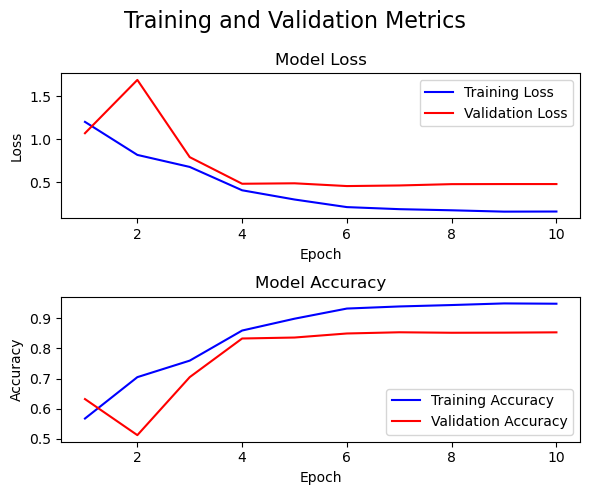

Best validation accuracy: 0.8540 (Epoch 7)
Final accuracy gap (train - val): 0.0953


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your training output
epochs = range(1, 11)
#train_loss = [1.2046, 0.8164, 0.6721, 0.5795, 0.4985, 0.4179, 0.3544, 0.3011, 0.2437, 0.2144]
#train_acc = [0.5643, 0.7060, 0.7622, 0.7950, 0.8245, 0.8527, 0.8794, 0.8968, 0.9164, 0.9263]
#val_loss = [1.1494, 0.9248, 0.7390, 0.9132, 0.5970, 0.6041, 0.6934, 0.6527, 0.6923, 0.8519]
#val_acc = [0.5924, 0.6811, 0.7340, 0.6747, 0.7854, 0.7898, 0.7632, 0.7981, 0.8010, 0.7495]


#train_loss = [0.2005, 0.1795, 0.1565, 0.1487, 0.1382, 0.1174, 0.1184, 0.1141, 0.1006, 0.1074]
#train_acc = [0.9314, 0.9385, 0.9450, 0.9500, 0.9530, 0.9601, 0.9598, 0.9612, 0.9663, 0.9625]
#val_loss = [0.8022, 0.6737, 0.8607, 0.8347, 0.7254, 0.6479, 0.7382, 0.9915, 0.9643, 0.8319]
#val_acc = [0.7741, 0.8196, 0.7589, 0.7780, 0.8045, 0.8340, 0.8174, 0.7507, 0.7609, 0.7872]

train_loss = [1.2014, 0.8165, 0.6764, 0.4045, 0.2970, 0.2085, 0.1845, 0.1714, 0.1557, 0.1570]
train_acc = [0.5668, 0.7046, 0.7596, 0.8598, 0.8992, 0.9330, 0.9400, 0.9447, 0.9501, 0.9491]
val_loss = [1.0693, 1.6902, 0.7904, 0.4805, 0.4858, 0.4536, 0.4606, 0.4760, 0.4770, 0.4769]
val_acc = [0.6316, 0.5115, 0.7047, 0.8333, 0.8365, 0.8500, 0.8540, 0.8524, 0.8528, 0.8538]


           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training & validation accuracy values
ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Calculate and print best validation accuracy
best_val_acc = max(val_acc)
best_epoch = val_acc.index(best_val_acc) + 1
print(f"Best validation accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


### Wrong, saves the last model and not the best

In [21]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch']


In [22]:
# Convert to TorchScript for faster inference
scripted_model = torch.jit.script(model)
scripted_model.save("model_scripted.pt")
